# Example optimisation with stochastic nonlocal modifications and gradient descent

## Imports and prep

In [1]:
from ship_routing.core import Route, WayPoint
from ship_routing.data import (
    load_currents,
    load_winds,
    load_waves,
)
from ship_routing.algorithms import (
    gradient_descent_across_track_left,
    gradient_descent_along_track,
    gradient_descent_time_shift,
    LargeIncrementError,
    InvalidGradientError,
    ZeroGradientsError,
)

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from copy import deepcopy
import tqdm

In [3]:
np.random.seed(345)

## Load and plot currents, winds, waves

In [4]:
currents = load_currents(
    data_file="/Users/wrath/src/git.geomar.de/willi-rath/ship_routing_data/data/cmems_mod_glo_phy_my_0.083deg_P1D-m_time_2021_lat_+10_+65_lon_-100_+010_uo-vo.zarr/",
    engine="zarr",
    chunks="auto",
)
currents["speed"] = ((currents.to_array() ** 2).sum("variable") ** 0.5).where(
    ~currents.uo.isnull()
)

currents

<xarray.Dataset> Size: 4GB
Dimensions:  (lat: 661, lon: 1321, time: 365)
Coordinates:
    depth    float32 4B ...
  * lat      (lat) float32 3kB 10.0 10.08 10.17 10.25 ... 64.75 64.83 64.92 65.0
  * lon      (lon) float32 5kB -100.0 -99.92 -99.83 -99.75 ... 9.833 9.917 10.0
  * time     (time) datetime64[ns] 3kB 2021-01-01 2021-01-02 ... 2021-12-31
Data variables:
    uo       (time, lat, lon) float32 1GB dask.array<chunksize=(38, 661, 1321), meta=np.ndarray>
    vo       (time, lat, lon) float32 1GB dask.array<chunksize=(38, 661, 1321), meta=np.ndarray>
    speed    (time, lat, lon) float32 1GB dask.array<chunksize=(38, 661, 1321), meta=np.ndarray>
Attributes: (12/24)
    Conventions:        CF-1.4
    bulletin_date:      2021-07-07 00:00:00
    bulletin_type:      operational
    comment:            CMEMS product
    domain_name:        GL12
    easting:            longitude
    ...                 ...
    northing:           latitude
    references:         http://www.mercator-ocean.fr
    source:             MERCATOR GLORYS12V1
    title:              daily mean fields from Global Ocean Physics Analysis ...
    z_max:              5727.9169921875
    z_min:              0.49402499198913574

In [5]:
winds = load_winds(
    data_file="/Users/wrath/src/git.geomar.de/willi-rath/ship_routing_data/data/cmems_obs-wind_glo_phy_my_l4_0.125deg_PT1H_time_2021_lat_+10_+65_lon_-100_+010_eastward_wind-northward_wind.zarr/",
    engine="zarr",
    chunks="auto",
)
winds["speed"] = ((winds.to_array() ** 2).sum("variable") ** 0.5).where(
    ~winds.uw.isnull()
)
winds

/Users/wrath/src/github.com/willirath/ship_routing/src/ship_routing/data.py:39: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 107. This could degrade performance. Instead, consider rechunking after loading.
  ds = xr.open_dataset(data_file, **kwargs)
/Users/wrath/src/github.com/willirath/ship_routing/src/ship_routing/data.py:39: UserWarning: The specified chunks separate the stored chunks along dimension "latitude" starting at index 395. This could degrade performance. Instead, consider rechunking after loading.
  ds = xr.open_dataset(data_file, **kwargs)
/Users/wrath/src/github.com/willirath/ship_routing/src/ship_routing/data.py:39: UserWarning: The specified chunks separate the stored chunks along dimension "longitude" starting at index 791. This could degrade performance. Instead, consider rechunking after loading.
  ds = xr.open_dataset(data_file, **kwargs)


<xarray.Dataset> Size: 41GB
Dimensions:  (time: 8760, lat: 440, lon: 880)
Coordinates:
  * lat      (lat) float32 2kB 10.06 10.19 10.31 10.44 ... 64.69 64.81 64.94
  * lon      (lon) float32 4kB -99.94 -99.81 -99.69 -99.56 ... 9.688 9.812 9.938
  * time     (time) datetime64[ns] 70kB 2021-01-01 ... 2021-12-31T23:00:00
Data variables:
    uw       (time, lat, lon) float32 14GB dask.array<chunksize=(107, 395, 791), meta=np.ndarray>
    vw       (time, lat, lon) float32 14GB dask.array<chunksize=(107, 395, 791), meta=np.ndarray>
    speed    (time, lat, lon) float32 14GB dask.array<chunksize=(107, 395, 791), meta=np.ndarray>
Attributes: (12/26)
    Conventions:                CF-1.6, ACDD-1.3
    date_created:               2024-03-25T23:58:22
    date_modified:              2024-03-25T23:58:22
    geospatial_lat_max:         89.9375
    geospatial_lat_min:         -89.9375
    geospatial_lat_resolution:  0.125
    ...                         ...
    project:                    Copernicus Marine Service Wind Thematic Assem...
    references:                 Copernicus Marine Service Product User Manual...
    summary:                    Global ocean 10-m stress-equivalent wind and ...
    time_coverage_end:          2023-12-21T23:00:00
    time_coverage_start:        2023-12-21T23:00:00
    title:                       Global Ocean - Wind and Stress - Hourly - Re...

In [6]:
waves = load_waves(
    data_file="/Users/wrath/src/git.geomar.de/willi-rath/ship_routing_data/data/cmems_mod_glo_wav_my_0.2deg_PT3H-i_time_2021_lat_+10_+65_lon_-100_+010_VHM0-VMDR.zarr/",
    engine="zarr",
    chunks="auto",
)

waves

<xarray.Dataset> Size: 4GB
Dimensions:  (time: 2920, lat: 276, lon: 551)
Coordinates:
  * lat      (lat) float32 1kB 10.0 10.2 10.4 10.6 10.8 ... 64.4 64.6 64.8 65.0
  * lon      (lon) float32 2kB -100.0 -99.8 -99.6 -99.4 ... 9.4 9.6 9.8 10.0
  * time     (time) datetime64[ns] 23kB 2021-01-01 ... 2021-12-31T21:00:00
Data variables:
    wh       (time, lat, lon) float32 2GB dask.array<chunksize=(200, 276, 551), meta=np.ndarray>
    VMDR     (time, lat, lon) float32 2GB dask.array<chunksize=(200, 276, 551), meta=np.ndarray>
Attributes: (12/30)
    CDI:                           Climate Data Interface version 1.9.8 (http...
    CDO:                           Climate Data Operators version 1.9.8 (http...
    Conventions:                   CF-1.6
    area:                          GLO
    contact:                       servicedesk.cmems@mercator-ocean.eu
    credit:                        E.U. Copernicus Marine Service Information...
    ...                            ...
    quality_information_document:   http://marine.copernicus.eu/documents/QUI...
    references:                    http://marine.copernicus.eu
    time_coverage_end:             20230430-21:00:00
    time_coverage_start:           20230430-00:00:00
    title:                         Mean fields from global wave model MFWAM o...
    version:                       1.2

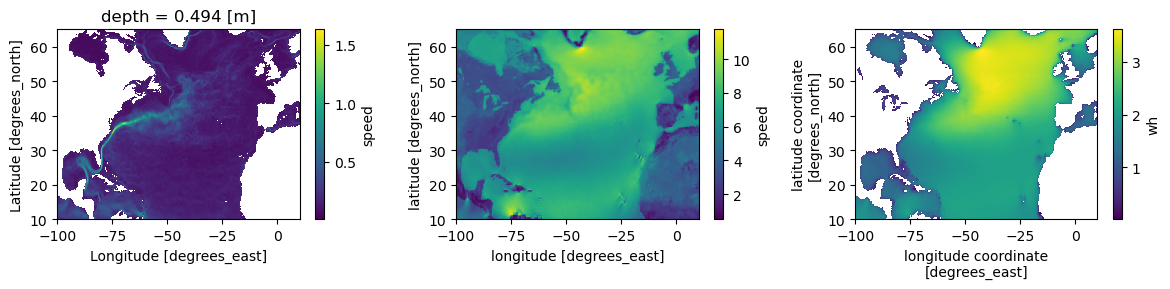

In [7]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3))

currents.speed.mean("time").plot(ax=ax[0])
winds.speed.mean("time").plot(ax=ax[1])
waves.wh.mean("time").plot(ax=ax[2])

fig.tight_layout();

## Define a route and have a look

In [8]:
route_0 = Route(
    way_points=(
        WayPoint(lon=-10, lat=50, time=np.datetime64("2021-08-09")),
        WayPoint(lon=-80.5, lat=30, time=np.datetime64("2021-08-19")),
    )
)
# refine to 12 hourly way points
refine_to = np.mean([l.speed_ms for l in route_0.legs]) * 12 * 3600.0
route_0 = route_0.refine(distance_meters=refine_to)
route_0

Route(way_points=(WayPoint(lon=np.float64(-10.0), lat=np.int64(50), time=np.datetime64('2021-08-09')), WayPoint(lon=-14.292201577420826, lat=50.261276172512616, time=np.datetime64('2021-08-09T11:59:59.999')), WayPoint(lon=-18.61708385116704, lat=50.36264428060363, time=np.datetime64('2021-08-09T23:59:59.999')), WayPoint(lon=-22.94574283062347, lat=50.302858182294756, time=np.datetime64('2021-08-10T11:59:59.999')), WayPoint(lon=-27.249088698314868, lat=50.082654353219056, time=np.datetime64('2021-08-10T23:59:59.999')), WayPoint(lon=-31.499266319154454, lat=49.70470817650217, time=np.datetime64('2021-08-11T11:59:59.999')), WayPoint(lon=-35.6709318555244, lat=49.173478785446754, time=np.datetime64('2021-08-11T23:59:59.999')), WayPoint(lon=-39.74225007322045, lat=48.49496299292714, time=np.datetime64('2021-08-12T11:59:59.999')), WayPoint(lon=-43.695532496104526, lat=47.676388700546255, time=np.datetime64('2021-08-12T23:59:59.999')), WayPoint(lon=-47.517500408033804, lat=46.72588167305242, 

In [9]:
print("speed (m/s)", np.mean([l.speed_ms for l in route_0.legs]))

speed (m/s) 7.134894006504661


## Subset the data

In [10]:
%time currents = currents.sel(time=slice(route_0.way_points[0].time, route_0.way_points[-1].time)).compute()
%time winds = winds.sel(time=slice(route_0.way_points[0].time, route_0.way_points[-1].time)).compute()
%time waves = waves.sel(time=slice(route_0.way_points[0].time, route_0.way_points[-1].time)).compute()

CPU times: user 609 ms, sys: 254 ms, total: 863 ms
Wall time: 340 ms
CPU times: user 6.91 s, sys: 2.71 s, total: 9.62 s
Wall time: 1.48 s
CPU times: user 95.2 ms, sys: 24.7 ms, total: 120 ms
Wall time: 49.7 ms


## Have a look

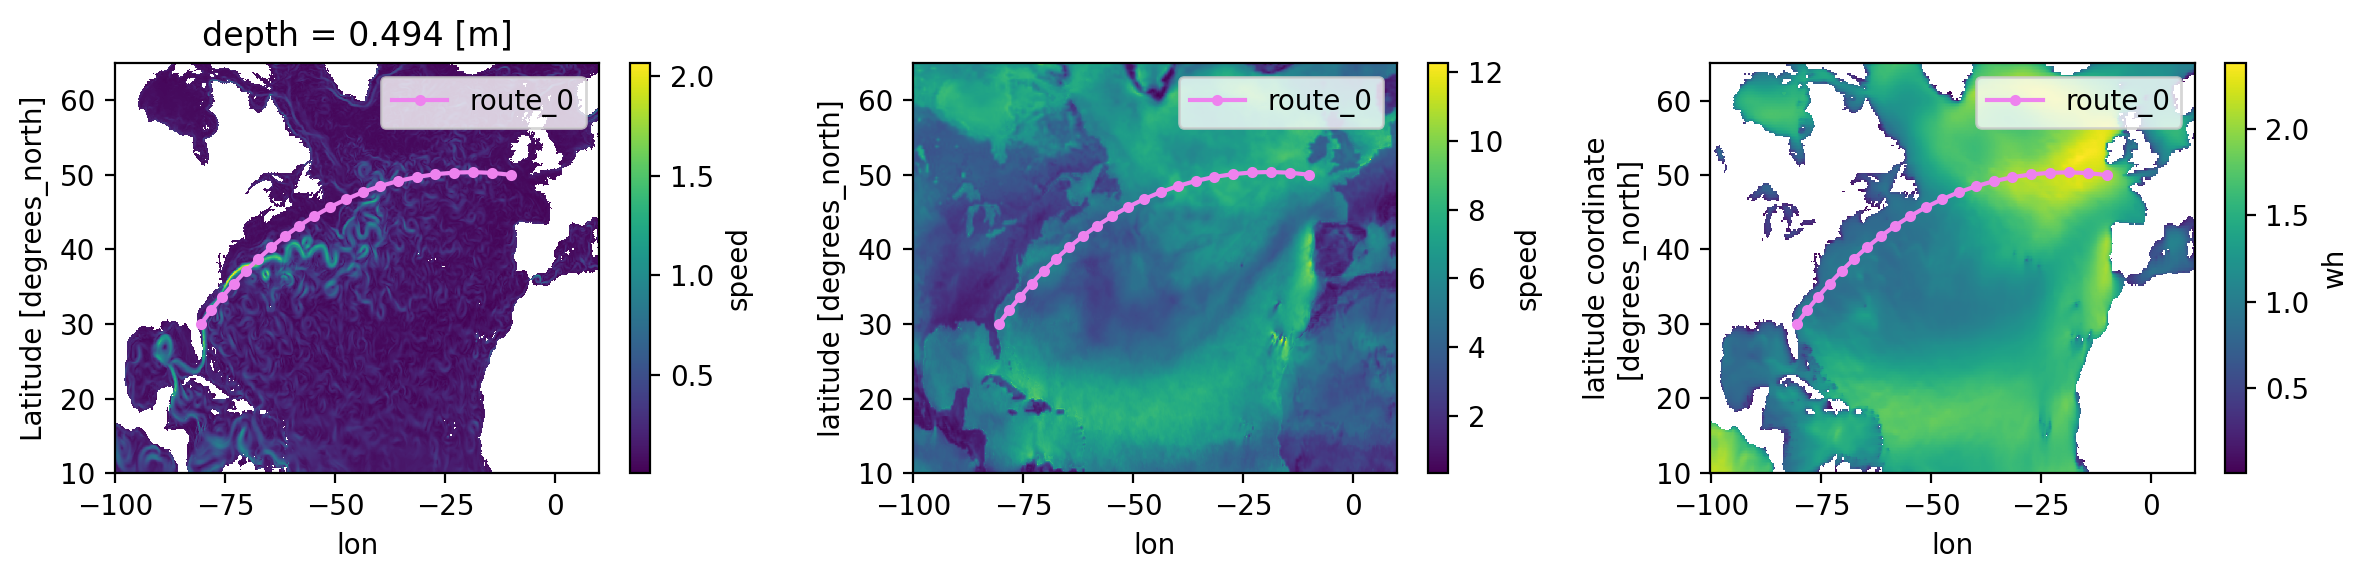

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3))

fig.set_dpi(200)

currents.speed.mean("time").plot(ax=ax[0])
winds.speed.mean("time").plot(ax=ax[1])
waves.wh.mean("time").plot(ax=ax[2])

for _ax in ax.flatten():
    route_0.data_frame.plot.line(
        x="lon", y="lat", marker=".", ax=_ax, color="violet", label="route_0"
    )

fig.tight_layout();

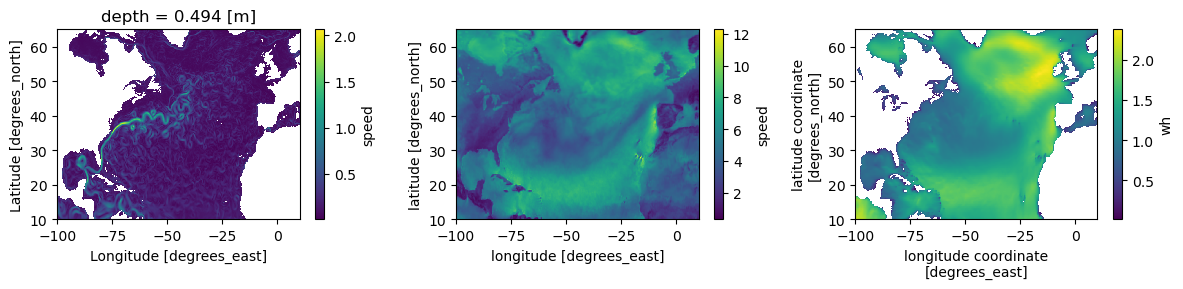

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3))

currents.speed.mean("time").plot(ax=ax[0])
winds.speed.mean("time").plot(ax=ax[1])
waves.wh.mean("time").plot(ax=ax[2])

fig.tight_layout();

## Keep track of cost

In [13]:
cost_steps = []

## Stochastic Optimisation

In [14]:
max_width = 0.75 * route_0.length_meters
max_dist_mod = 0.75 * max_width
route_1 = route_0
cost = route_1.cost_through(
    current_data_set=currents,
    wave_data_set=waves,
    wind_data_set=winds,
)
cost_steps.append(cost)

accepted = 0
n_reset = 0
for n in tqdm.tqdm(range(200)):
    _route_1 = route_1.move_waypoints_left_nonlocal(
        center_distance_meters=np.random.uniform(
            max_width / 2.0, route_1.length_meters - max_width / 2.0
        ),
        width_meters=max_width,
        max_move_meters=np.random.uniform(-max_dist_mod, max_dist_mod),
    )
    _cost = _route_1.cost_through(
        current_data_set=currents,
        wave_data_set=waves,
        wind_data_set=winds,
    )
    if not np.isnan(_cost) and _cost < cost:
        route_1 = _route_1
        cost = _cost
        accepted += 1
        cost_steps.append(cost)
    if (accepted + 1) / (n_reset + 1) < 0.05:
        n_reset = 0
        accepted = 0
        max_dist_mod /= 2.0**0.5
        max_width /= 2.0**0.5
        print(".")
    n_reset += 1

 20%|████████▌                                 | 41/200 [00:10<00:41,  3.80it/s]

.


 50%|████████████████████▋                    | 101/200 [00:26<00:25,  3.82it/s]

.


 60%|████████████████████████▊                | 121/200 [00:31<00:20,  3.81it/s]

.


 70%|████████████████████████████▉            | 141/200 [00:37<00:15,  3.78it/s]

.


100%|█████████████████████████████████████████| 200/200 [00:52<00:00,  3.79it/s]


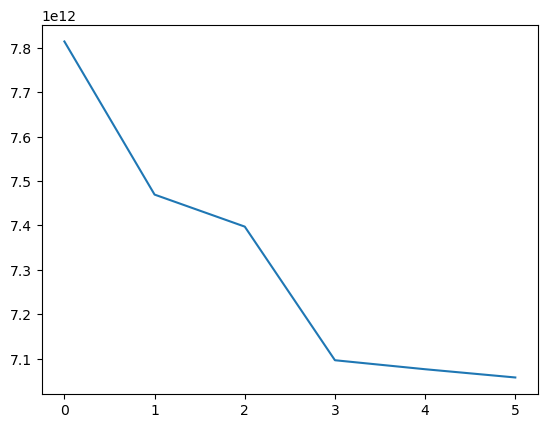

In [15]:
plt.plot(cost_steps)

## Show results

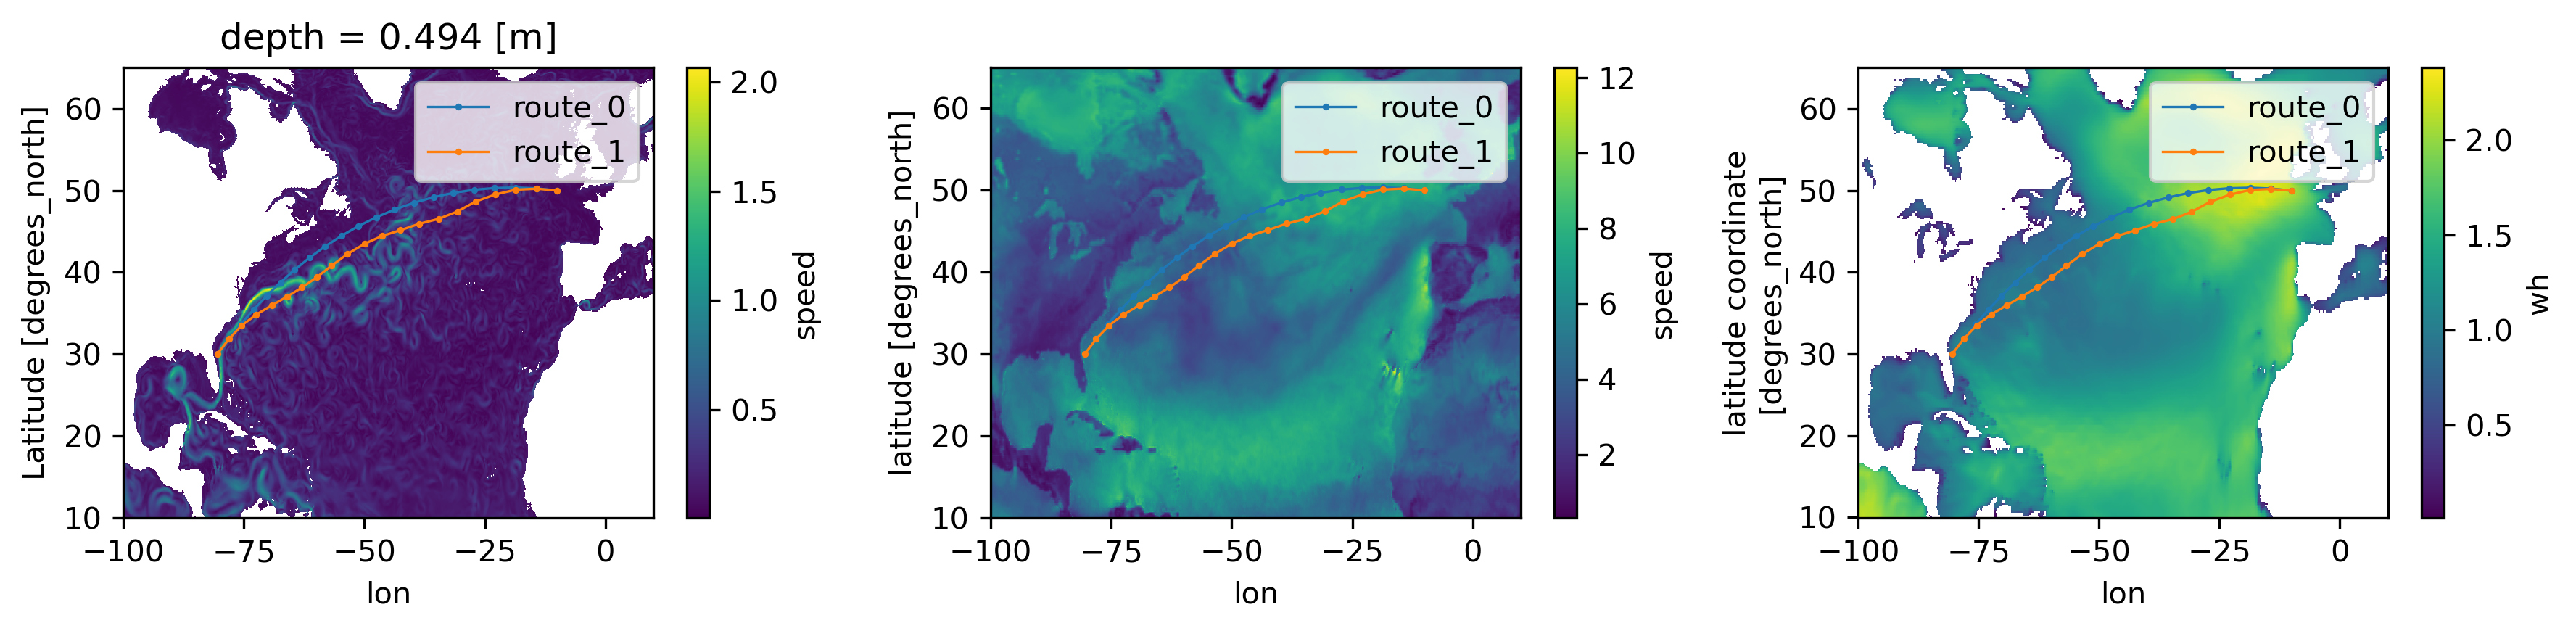

In [16]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3))

fig.set_dpi(300)

currents.speed.mean("time").plot(ax=ax[0])
winds.speed.mean("time").plot(ax=ax[1])
waves.wh.mean("time").plot(ax=ax[2])

for _ax in ax.flatten():
    route_0.data_frame.plot.line(
        x="lon",
        y="lat",
        marker=".",
        markersize=2.5,
        ax=_ax,
        label="route_0",
        linewidth=0.8,
    )
    route_1.data_frame.plot.line(
        x="lon",
        y="lat",
        marker=".",
        markersize=2.5,
        ax=_ax,
        label="route_1",
        linewidth=0.8,
    )

fig.tight_layout();

In [17]:
print(
    "reduction",
    (route_1.cost_through(currents) - route_0.cost_through(currents))
    / route_0.cost_through(currents)
    * 100.0,
    "%",
)

reduction 0.8823832710466736 %


In [18]:
print(
    "length +",
    (route_1.length_meters - route_0.length_meters) / route_0.length_meters * 100.0,
    "%",
)

length + 0.9771049274971494 %


## Gradient descents

In [ ]:
learning_rate_percent_time = 0.2
time_increment = 1_200
learning_rate_percent_along = 0.2
dist_shift_along = 10_000
learning_rate_percent_across = 0.2
dist_shift_across = 10_000

route_2 = route_1
cost_steps_grad = []

for n in tqdm.tqdm(range(10)):
    try:
        route_2 = gradient_descent_time_shift(
            route=route_2,
            current_data_set=currents,
            wave_data_set=waves,
            wind_data_set=winds,
            time_shift_seconds=time_increment,
            learning_rate_percent=learning_rate_percent_time,
        )
        cost_steps_grad.append(
            route_2.cost_through(
                current_data_set=currents,
                wave_data_set=waves,
                wind_data_set=winds,
            )
        )
    except ZeroGradientsError:
        # converged, just pass
        pass
    except InvalidGradientError:
        time_increment /= 2.0
        learning_rate_percent_time /= 2.0
    except LargeIncrementError:
        learning_rate_percent_time /= 2.0

    try:
        route_2 = gradient_descent_across_track_left(
            route=route_2,
            current_data_set=currents,
            wave_data_set=waves,
            wind_data_set=winds,
            distance_meters=dist_shift_across,
            learning_rate_percent=learning_rate_percent_across,
        )
        cost_steps_grad.append(
            route_2.cost_through(
                current_data_set=currents,
                wave_data_set=waves,
                wind_data_set=winds,
            )
        )
    except ZeroGradientsError:
        # converged, just pass
        pass
    except InvalidGradientError:
        dist_shift_across /= 2.0
        learning_rate_percent_across /= 2.0
    except LargeIncrementError:
        learning_rate_percent_across /= 2.0

    try:
        route_2 = gradient_descent_along_track(
            route=route_2,
            current_data_set=currents,
            wave_data_set=waves,
            wind_data_set=winds,
            distance_meters=dist_shift_along,
            learning_rate_percent=learning_rate_percent_along,
        )
        cost_steps_grad.append(
            route_2.cost_through(
                current_data_set=currents,
                wave_data_set=waves,
                wind_data_set=winds,
            )
        )
    except ZeroGradientsError:
        # converged, just pass
        pass
    except InvalidGradientError:
        dist_shift_along /= 2.0
        learning_rate_percent_along /= 2.0
    except LargeIncrementError:
        learning_rate_percent_along /= 2.0

 70%|██████████████████████████████▊             | 7/10 [03:38<01:33, 31.26s/it]

In [ ]:
plt.plot(cost_steps_grad)

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3))

fig.set_dpi(300)

currents.speed.mean("time").plot(ax=ax[0])
winds.speed.mean("time").plot(ax=ax[1])
waves.wh.mean("time").plot(ax=ax[2])

for _ax in ax.flatten():
    route_0.data_frame.plot.line(
        x="lon",
        y="lat",
        marker=".",
        markersize=2.5,
        ax=_ax,
        label="route_0",
        linewidth=0.8,
    )
    route_1.data_frame.plot.line(
        x="lon",
        y="lat",
        marker=".",
        markersize=2.5,
        ax=_ax,
        label="route_1",
        linewidth=0.8,
    )
    route_2.data_frame.plot.line(
        x="lon",
        y="lat",
        marker=".",
        markersize=2.5,
        ax=_ax,
        label="route_2",
        linewidth=0.8,
    )

fig.tight_layout();

In [ ]:
print(
    "reduction w.r.t. initial route",
    (
        route_2.cost_through(
            current_data_set=currents,
            wave_data_set=waves,
            wind_data_set=winds,
        )
        - route_0.cost_through(
            current_data_set=currents,
            wave_data_set=waves,
            wind_data_set=winds,
        )
    )
    / route_0.cost_through(
        current_data_set=currents,
        wave_data_set=waves,
        wind_data_set=winds,
    )
    * 100.0,
    "%",
)

In [ ]:
print(
    "length  w.r.t. initial route +",
    (route_2.length_meters - route_0.length_meters) / route_0.length_meters * 100.0,
    "%",
)

In [ ]:
print(
    "reduction w.r.t. stochastic opt route",
    (
        route_2.cost_through(
            current_data_set=currents,
            wave_data_set=waves,
            wind_data_set=winds,
        )
        - route_1.cost_through(
            current_data_set=currents,
            wave_data_set=waves,
            wind_data_set=winds,
        )
    )
    / route_1.cost_through(
        current_data_set=currents,
        wave_data_set=waves,
        wind_data_set=winds,
    )
    * 100.0,
    "%",
)

In [ ]:
print(
    "length  w.r.t. stochastic opt route +",
    (route_2.length_meters - route_1.length_meters) / route_1.length_meters * 100.0,
    "%",
)